In [1]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits
import pandas as pd
import copy
from lenstronomy.Util import util
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Plots.lens_plot import lens_model_plot
import lenstronomy.Plots.plot_util as plot_util
%matplotlib ipympl


In [2]:
# set up DES camera settings for simulation
deltaPix = 0.2637  # pixel size in arcsec
numPix = 45  # number of pixels per axis
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)  # cosmological model

DES_camera = {'read_noise': 7.,  # std of noise from read-out (in electrons)
              'pixel_scale': deltaPix,
              'ccd_gain': 6.  # electrons/ADU (analog-to-digital unit)
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                  'sky_brightness': 35.01,  # sky brightness (in mag/arcsec^2)
                  'magnitude_zero_point': 30,  # mag where 1 count/s/arcsec^2 is registered (ADUs)
                  'num_exposures': 7,  # number of combined exposures
                  'seeing': 1.12,  # fwhm the PSF
                  'psf_type': 'GAUSSIAN',  # PSF Model ('GAUSSIAN' or 'PIXEL')
                  }

DES_r_band_obs = {'exposure_time': 90.,
                  'sky_brightness': 34.7,
                  'magnitude_zero_point': 30,
                  'num_exposures': 7,
                  'seeing': 1.12,
                  'psf_type': 'GAUSSIAN'
                  }

DES_i_band_obs = {'exposure_time': 90.,
                  'sky_brightness': 35.1,
                  'magnitude_zero_point': 30,
                  'num_exposures': 7,
                  'seeing': 1.12,
                  'psf_type': 'GAUSSIAN'
                  }

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)


In [3]:
def simulation(ra_source, dec_source):
    """
    Input: ra and dec coordinates of source position
    Output: np array (45, 45, 3) of simulated image data
    """
    theta_E = 2  # arbitrary choice for einstein rad.
    center_x = 0  # arbitrary choice for x coord of lens position (arcsec)
    center_y = 0  # arbitrary choice for y coord of lens position (arcsec)

    # Lens Model
    lens_model_list = ['SIE']  # lens model(s) to use
    kwargs_lens = [{'theta_E': theta_E,
                    'e1': 0.1, 'e2': -0.2,
                    'center_x': center_x, 'center_y': center_y}]

    # Point Source Model
    kwargs_ps = [{'ra_source': ra_source, 'dec_source': dec_source}]

    # Light Model
    light_model = ['SERSIC_ELLIPSE']  # light model(s) to use
    lightModel = LightModel(light_model_list=light_model)  # light model class

    # lens light
    kwargs_lens_light_mag_g = [{'magnitude': 18,
                                'R_sersic': 0.1, 'n_sersic': 2,
                                'e1': 0.0, 'e2': 0.0,
                                'center_x': center_x, 'center_y': center_y}]
    # extended source light
    kwargs_source_mag_g = [{'magnitude': 20,
                            'R_sersic': 0.1, 'n_sersic': 1,
                            'e1': 0.0, 'e2': 0.0,
                            'center_x': ra_source, 'center_y': dec_source}]
    # point source light
    kwargs_ps_mag_g = [{'magnitude': 21,
                        'ra_source': ra_source, 'dec_source': dec_source}]

    # Combine models
    kwargs_model = {'lens_model_list': lens_model_list,  # lens model  
                    'lens_light_model_list': light_model,  # light model
                    'source_light_model_list': light_model,  # extended source light model
                    'point_source_model_list': ['SOURCE_POSITION']}  # input is source position

    # Numerics
    kwargs_numerics = {'point_source_supersampling_factor': 10}

    # Configurations for simulated image for G, R, I bands
    sim_g = SimAPI(numpix=numPix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model)
    sim_r = SimAPI(numpix=numPix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model)
    sim_i = SimAPI(numpix=numPix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model)

    # Set image model class
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    # Define parameters for R and I bands:
    # r-band
    g_r_source = 1  # color mag_g - mag_r for source
    g_r_lens = -1  # color mag_g - mag_r for lens light
    g_r_ps = 0
    kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
    kwargs_lens_light_mag_r[0]['magnitude'] -= g_r_lens

    kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
    kwargs_source_mag_r[0]['magnitude'] -= g_r_source

    kwargs_ps_mag_r = copy.deepcopy(kwargs_ps_mag_g)
    kwargs_ps_mag_r[0]['magnitude'] -= g_r_ps

    # i-band
    g_i_source = 2
    g_i_lens = -2
    g_i_ps = 0
    kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
    kwargs_lens_light_mag_i[0]['magnitude'] -= g_i_lens

    kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
    kwargs_source_mag_i[0]['magnitude'] -= g_i_source

    kwargs_ps_mag_i = copy.deepcopy(kwargs_ps_mag_g)
    kwargs_ps_mag_i[0]['magnitude'] -= g_i_ps

    # translate magnitude kwargs into amplitude kwargs
    kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g,
                                                                                  kwargs_source_mag_g,
                                                                                  kwargs_ps_mag_g)
    kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_r.magnitude2amplitude(kwargs_lens_light_mag_r,
                                                                                  kwargs_source_mag_r,
                                                                                  kwargs_ps_mag_r)
    kwargs_lens_light_i, kwargs_source_i, kwargs_ps_i = sim_i.magnitude2amplitude(kwargs_lens_light_mag_i,
                                                                                  kwargs_source_mag_i,
                                                                                  kwargs_ps_mag_i)

    image_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g, kwargs_ps_g)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r, kwargs_ps_r)
    image_i = imSim_i.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i, kwargs_ps_i)

    # Create image
    img = np.zeros((numPix, numPix, 3), dtype=float)  # (45, 45, 3)
    img[:, :, 0] = plot_util.sqrt(image_g, scale_min=0, scale_max=10000)
    img[:, :, 1] = plot_util.sqrt(image_r, scale_min=0, scale_max=10000)
    img[:, :, 2] = plot_util.sqrt(image_i, scale_min=0, scale_max=10000)

    return img, kwargs_lens



In [4]:
# define event functions
def onclick(event):
    """
    Input: Click on simulated image
    Output: Printed text stating ra_source and dec_source
    """
    if event.x <= 1000:
        x_source = event.xdata
        y_source = event.ydata

        ra_source = (x_source-(numPix/2))*deltaPix
        dec_source = (y_source-(numPix/2))*deltaPix

    elif event.x > 1000:
        ra_source = event.xdata
        dec_source = event.ydata

    else:
        ra_source = 0
        dec_source = 0

    img, _ = simulation(ra_source, dec_source)

    ax[1].clear()
    lens_model_plot(ax[1], lensModel, kwargs_lens,
                    sourcePos_x=ra_source,
                    sourcePos_y=dec_source,
                    **kwargs_lens_plot)

    ax[0].imshow(img, origin='lower')

    text.set_c(color='ivory')
    text.set_text(f'ra_source = {round(ra_source, 2)}, dec_source = {round(dec_source, 2)}')


def on_close(event):
    """
    Input: any key pressed
    Output: closes image
    '"""
    plt.close()



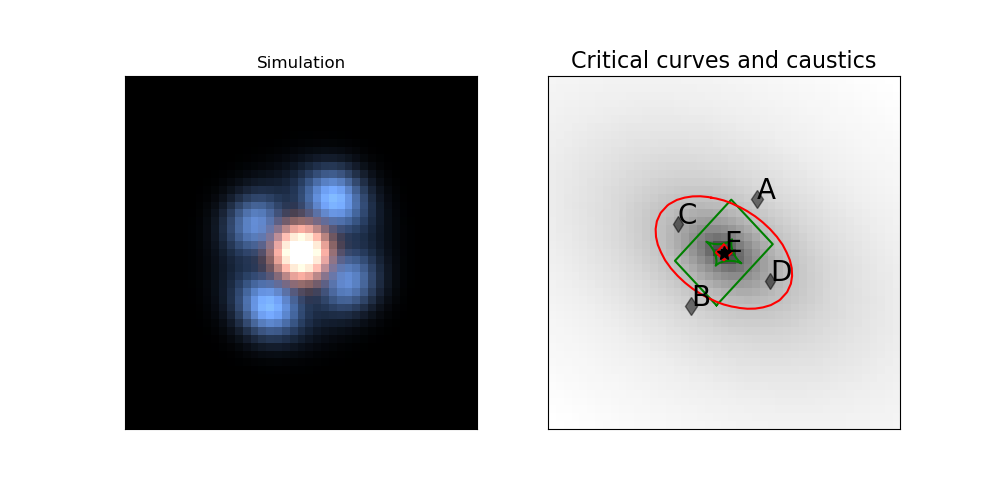

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # set up figure

# Simulated Image
img, kwargs_lens = simulation(0, 0)  # start at (0, 0)
ax[0].imshow(img, origin='lower')
ax[0].set_title('Simulation')
ax[0].set_xticks([])
ax[0].set_yticks([])

# set empty text at bottom left of simulated image
text = ax[0].text(0, 0, "", va="bottom", ha="left", fontsize=10)

# Lens Model Plot
lensModel = LensModel(lens_model_list=['SIE'])  # set lens model

kwargs_lens_plot = {'with_caustics': True,  # show critical curves and caustics
                    'fast_caustic': True,
                    'point_source': True,  # show calculated image positions
                    'with_convergence': True,  # show convergence
                    'numPix': numPix,
                    'deltaPix': deltaPix}

# Start with source at (0, 0)
lens_model_plot(ax[1], lensModel, kwargs_lens,
                sourcePos_x=0, sourcePos_y=0,
                **kwargs_lens_plot)

ax[1].set_title('Critical curves and caustics', fontsize=16)
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()  # show plot in interactive window

# run event functions
cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('key_press_event', on_close)


Remember to press a key when you are done to close the image!